# Import

In [1]:
!pip install pyproj
!pip install pycraf
!pip install swifter
!pip install joblib
!pip  install -U  geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=b909603ebab3e42bc05726e1d452937add8b8ed3944e28a195a5581e1a05eaef
  Stored in directory: /root/.cache/pip/wheels/2b/5e/f2/3931524f702ffd03309e96d35ee2fbf9c61c27377511ee8d4c
Successfully built swifter
Looking in indexes: https://pypi.org/simple, https://us-py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import swifter
import glob
import os
from sklearn.linear_model import LinearRegression
from numpy import mean
from datetime import datetime
from joblib import Parallel, delayed


In [4]:
import pycraf.geospatial as geo
import astropy.units as u
import math
from sklearn.neighbors import BallTree

# Import DVF
# ** LA SORTIE DOIT S'APPELER 'data'**

In [ ]:
def stat_sur_filtre(data):
  print(data.shape)
  print(data.groupby(['LIBEPCI']).size())
  return data.groupby(['LIBEPCI', 'type_local']).size()

In [ ]:
def stat_before_after(data,clean_data):
    data.drop_duplicates(inplace=True)
    mask=(data.nature_mutation=="Vente")
    data=data[mask]
    mask=(data.type_local=="Appartement")|(data.type_local=="Maison")
    before_clean=data[mask]
    total_metropole_before=stat_sur_filtre(before_clean)
    total_metropole_after=stat_sur_filtre(clean_data)
    taux=(total_metropole_before-total_metropole_after)*100/total_metropole_before
    taux=taux.sort_values(ascending=False)
    result=pd.DataFrame(taux).reset_index().set_index('LIBEPCI')
    result.columns=['type_local','pourcentage (%)']
    for col in ["Appartement",'Maison']:
        result[result.type_local==col].sort_values(by='pourcentage (%)',ascending=False).plot.barh()
        plt.title(col)
    

In [ ]:
# data=pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/Challenge/GROUP4/TEDONZE/base_de_données/datadvf20*.csv"))))
data=pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/Shareddrives/BDC Meilleur Taux Grp 4/base de données/datadvf20*.csv"))))

<ipython-input-5-83c572047224>:2: DtypeWarning: Columns (8,10,12,14,16,17,18,20,22,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/Shareddrives/BDC Meilleur Taux Grp 4/base de données/datadvf20*.csv"))))
<ipython-input-5-83c572047224>:2: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/Shareddrives/BDC Meilleur Taux Grp 4/base de données/datadvf20*.csv"))))
<ipython-input-5-83c572047224>:2: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/Shareddrives/BDC Meilleur Taux Grp 4/base de données/datadvf20*.csv"))))
<ipython-input-5-83c572047224>:2: DtypeWarning: Columns (8,

In [ ]:
data.shape

# Création des métropoles top 10 et Suppression des multiventes


## Fonction de création des métropoles

In [ ]:
# import the table which defines the metrpole (EPCI)
metropoles = pd.read_csv("/Challenge/GROUP4/TEDONZE/base_de_données/metropoles_communes.csv", delimiter = ';', header = 5)
# metropoles = pd.read_csv("/content/drive/Shareddrives/BDC Meilleur Taux Grp 4/base de données/metropoles_communes.csv", delimiter = ';', header = 5)

In [ ]:
def zone_top(df, nb_top_zone):
  """ sélectionner les zones où il y a le plus de mutations """
  
  # correct the spelling of somme commune
  df.loc[df.nom_commune.str.startswith('Marseille '), 'nom_commune'] = 'Marseille'
  df.loc[df.nom_commune.str.startswith('Lyon '), 'nom_commune'] = 'Lyon'
  df.loc[df.nom_commune.str.startswith('Paris '), 'nom_commune'] = 'Paris'
  # merge dvf and metropole
  df = df.merge(metropoles, how = 'left',  left_on = 'nom_commune', right_on = 'LIBGEO')
  # pick the areas where we have the higher number of transaction
  most_frequent = df['LIBEPCI'].value_counts().head(nb_top_zone).index.to_list()
  df = df.loc[df['LIBEPCI'].isin(most_frequent)]

  return df

## Création et récupération des biens dans le top 10 des métropoles 

In [ ]:
data_top = zone_top(data,10)
data_top.shape

(3271788, 46)

# Fonction de clean, notamment des multiventes

In [ ]:
def clean_type(clean_data,type_bien):
    mask = (clean_data.type_local == type_bien)
    clean_data = clean_data[mask]
    a = clean_data.groupby('index_group')['numero_disposition'].nunique()
    b = clean_data[clean_data.index_group.isin(a[a==1].index.to_list())].groupby('index_group').size()
    to_drop = b[b>1].index.to_list()
    clean_data = clean_data[~clean_data.index_group.isin(to_drop)]
    return clean_data

In [ ]:
def clean_multivente(data):
    '''
    - drop the duplicates and only keep the 'Sale' transaction
    - drop all mutations with several disposition id (more complex mutations)
    - if we have the same mutation id several rows we filter by flat or house and make sure that we keep only one row for each type of good
    
        '''
    data.drop_duplicates(inplace=True)
    mask=(data.nature_mutation=="Vente")
    data=data[mask]
    data['index_group'] = data["id_mutation"].astype('string') + data['date_mutation'].astype('string')
    a = data.groupby('index_group')['numero_disposition'].nunique()
    to_drop = a[a>1].index.to_list()
    data = data[~data.index_group.isin(to_drop)]
    
    return pd.concat([clean_type(data,"Appartement"),clean_type(data,"Maison")])

# Nettoyage des multiventes

In [ ]:
clean_data = clean_multivente(data_top)
clean_data.shape

C:\Users\ntedonze\AppData\Local\Temp\2\ipykernel_17360\47736123.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index_group'] = data["id_mutation"].astype('string') + data['date_mutation'].astype('string')


(1054491, 47)

(1269091, 46)
LIBEPCI
Bordeaux Métropole                     76229
Montpellier Méditerranée Métropole     45054
Métropole Européenne de Lille         104086
Métropole Nice Côte d'Azur             72038
Métropole d'Aix-Marseille-Provence    147646
Métropole de Lyon                     115929
Métropole du Grand Paris              529947
Nantes Métropole                       64007
Rennes Métropole                       42210
Toulouse Métropole                     71945
dtype: int64
(1054491, 47)
LIBEPCI
Bordeaux Métropole                     63358
Montpellier Méditerranée Métropole     38386
Métropole Européenne de Lille          86268
Métropole Nice Côte d'Azur             59387
Métropole d'Aix-Marseille-Provence    115993
Métropole de Lyon                      93387
Métropole du Grand Paris              445347
Nantes Métropole                       54995
Rennes Métropole                       36644
Toulouse Métropole                     60726
dtype: int64


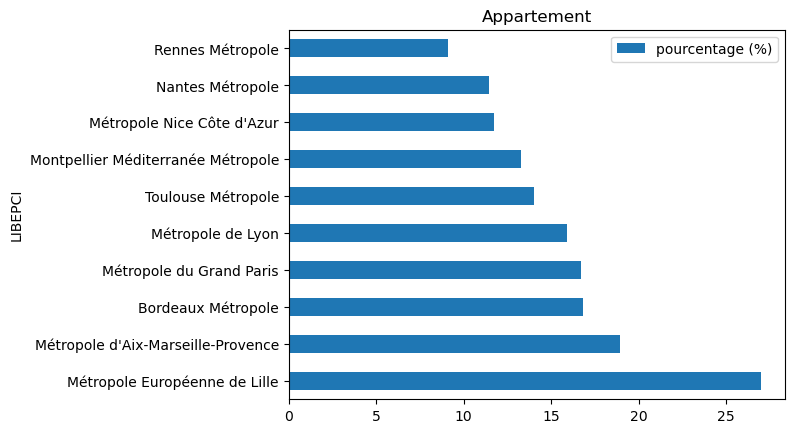

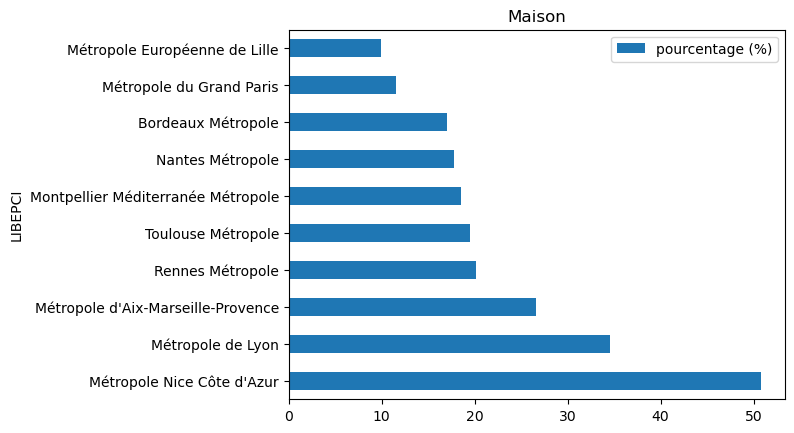

In [ ]:
stat_before_after(data_top,clean_data)

# Fonction closest GENERALE

In [ ]:
def get_nearest(src_points, candidates, k_neighbors):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size = 15, metric = 'haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k = k_neighbors)

    return (indices, distances)

def nearest_neighbor(left_gdf, right_gdf, k_neighbors, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians_x = left_gdf[left_geom_col].x.apply(lambda geom: geom * np.pi / 180)
    left_radians_y = left_gdf[left_geom_col].y.apply(lambda geom: geom * np.pi / 180)
    left_radians = np.c_[left_radians_x, left_radians_y]

    right_radians_x = right[right_geom_col].x.apply(lambda geom: geom * np.pi / 180)
    right_radians_y = right[right_geom_col].y.apply(lambda geom: geom * np.pi / 180)
    right_radians = np.c_[right_radians_x, right_radians_y]

    closest, dist = get_nearest(src_points = left_radians, candidates = right_radians, k_neighbors = k_neighbors)

    return closest


def my_choose_closest(dvf, table_info, k_neighbors, metric_interest, name_new_metric, reg=False):
    """ 
    get our metric of interest in the original dataframe
    calculated from the table_info with the function applied to the k_neighbors closest neighbors in the table_info dataframe
    
    """
    dvf[name_new_metric] = np.nan
    closest = nearest_neighbor(dvf, table_info.reset_index(drop=True), k_neighbors, return_dist = True)
    dvf['indices'] = list(closest)
    

    if reg:
        
        def apply_linear_regression(row, metric_interest):
            indices = row['indices']
            X = table_info.loc[indices, ['surface_reelle_bati', 'nombre_pieces_principales']].values
            prix = table_info.loc[indices, metric_interest].values

            lr = LinearRegression()
            lr.fit(X, prix)
    
            return lr.intercept_
        dvf[name_new_metric] = dvf.swifter.apply(
            lambda row: apply_linear_regression(row, metric_interest),
            axis=1
        )
    else:
        dvf[name_new_metric] = dvf['indices'].apply(lambda x: table_info[metric_interest].iloc[x].mean())

    return dvf

# Préparation DVF

## Fonctions d'actualisation temporelle des prix

In [ ]:
path_valeur_indice="/Challenge/GROUP4/TEDONZE/valeurs_trimestrielles.csv"
path_zonage_immo="/Challenge/GROUP4/TEDONZE/Zonage_abc_communes_2022.xlsx"

On définit les différentes fonctions utilisées ensuite

In [ ]:
def create_columns(data):
    liste_var=data.columns
    for i in liste_var:
        if 'Appartement' in i :
            new_var= i.replace('Appartement', 'Maison' )
            if new_var not in liste_var:
                data[new_var]=data[i]*data['coeff_appart_a_maison']
        if 'Maison' in i :
            new_var= i.replace('Maison', 'Appartement' )
            if new_var not in liste_var:
                data[new_var]=data[i]*data['coeff_maison_a_appart']
    return data

def commune (x):
    commune=str(x)
    commune_new=commune
    if len(commune)==4:
        commune_new='0'+commune
    return commune_new

def fill_zone(data):
    x=data['Zone ABC']
    nom=data['nom_commune']
    if nom in liste_Marseille:
        zone='Marseille'
    elif nom in liste_lyon:
        zone='Lyon'
    elif nom in liste_paris:
        zone='Paris'
    elif nom in ['Lille']:
        zone='Lille'   
    elif pd.isna(x):
        if nom not in liste_complete:
            zone= 'C'
    else:
        zone=x
    return zone


def get_trimestre(data):
    date=data['date_vente']
    mois=int(date.month)
    year=date.year
    trimestre=''
    if mois<4:
        trimestre='T1'
    elif (mois>=4) and (mois<7):
        trimestre='T2'
    elif (mois>=7) and (mois<10):
        trimestre='T3' 
    else:
        trimestre='T4' 
    trim_vente=str(year)+'-'+str(trimestre)
    return trim_vente

    
liste_grande_ville=['Indice des prix des logements anciens - Agglomération de Marseille - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS',
                   'Indice des prix des logements anciens - Agglomération de Lille - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS',
                   'Indice des prix des logements anciens - Agglomération de Lyon - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS',
                   'Indice des prix des logements anciens - Paris - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS',
                   'Indice des prix des logements anciens - France métropolitaine - Appartements - Base 100 en moyenne annuelle 2015 - série CVS',
                   'Indice des prix des logements anciens - France métropolitaine - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS',
                   "Indice des prix des logements anciens - Zone A du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS",
                   "Indice des prix des logements anciens - Zone A bis du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS",
                   "Indice des prix des logements anciens - Zone B1 du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS",
                   "Indice des prix des logements anciens - Zone B2 du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS",
                   "Indice des prix des logements anciens - Zone C du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS"]

liste_Marseille=['Marseille','Marseille 2e Arrondissement',
       'Marseille 3e Arrondissement', 'Marseille 1er Arrondissement',
       'Marseille 15e Arrondissement', 'Marseille 14e Arrondissement',
       'Marseille 4e Arrondissement', 'Marseille 16e Arrondissement',
       'Marseille 7e Arrondissement', 'Marseille 10e Arrondissement',
       'Marseille 6e Arrondissement', 'Marseille 5e Arrondissement',
       'Marseille 8e Arrondissement', 'Marseille 9e Arrondissement',
       'Marseille 12e Arrondissement', 'Marseille 13e Arrondissement',
       'Marseille 11e Arrondissement']
                 
liste_lyon=['Lyon','Lyon 9e Arrondissement',
       'Lyon 1er Arrondissement', 'Lyon 2e Arrondissement',
       'Lyon 5e Arrondissement', 'Lyon 4e Arrondissement',
       'Lyon 8e Arrondissement', 'Lyon 3e Arrondissement',
       'Lyon 7e Arrondissement', 'Lyon 6e Arrondissement']
                 
liste_paris=['Paris','Paris 8e Arrondissement',
       'Paris 3e Arrondissement', 'Paris 1er Arrondissement',
       'Paris 18e Arrondissement', 'Paris 7e Arrondissement',
       'Paris 5e Arrondissement', 'Paris 6e Arrondissement',
       'Paris 11e Arrondissement', 'Paris 13e Arrondissement',
       'Paris 10e Arrondissement', 'Paris 9e Arrondissement',
       'Paris 12e Arrondissement', 'Paris 14e Arrondissement',
       'Paris 15e Arrondissement', 'Paris 16e Arrondissement',
       'Paris 17e Arrondissement', 'Paris 20e Arrondissement',
       'Paris 19e Arrondissement', 'Paris 2e Arrondissement',
       'Paris 4e Arrondissement']

liste_complete=liste_paris+liste_lyon+liste_Marseille

On définit la fonction d'actulisation des prix, qui rajoute une colomne coefficient_actualisation

In [ ]:
def get_coeff_actu(data,base_indice_grand,trimestre_actu):
        zone=data['vrai_zone']
        trimestre=data['trimestre_vente']
        type_bien=data['type_local']
        ligne=''    
        if zone=='Paris':
            if type_bien=='Appartement':
                ligne='Indice des prix des logements anciens - Paris - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS'
            else:
                ligne='Indice des prix des logements anciens - Paris - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS'

        elif zone=='Marseille':
            if type_bien=='Appartement':
                ligne='Indice des prix des logements anciens - Agglomération de Marseille - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS'
            else:
                ligne='Indice des prix des logements anciens - Agglomération de Marseille - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS'

        elif zone=='Lyon':
            if type_bien=='Appartement':
                ligne='Indice des prix des logements anciens - Agglomération de Lyon - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS'
            else:
                ligne='Indice des prix des logements anciens - Agglomération de Lyon - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS'

        elif zone=='Lille':
            if type_bien=='Appartement':
                ligne='Indice des prix des logements anciens - Agglomération de Lille - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS'
            else:
                ligne='Indice des prix des logements anciens - Agglomération de Lille - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS'

        elif zone=='A':
            ligne="Indice des prix des logements anciens - Zone A du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS"
        elif zone=='Abis':
            ligne="Indice des prix des logements anciens - Zone A bis du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS"
        elif zone=='B1':
            ligne="Indice des prix des logements anciens - Zone B1 du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS"
        elif zone=='B2':
            ligne="Indice des prix des logements anciens - Zone B2 du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS"
        elif zone=='C':
            ligne="Indice des prix des logements anciens - Zone C du Zonage A, B, C - Base 100 en moyenne annuelle 2015 - Série CVS"
        
        # we only keep the row we are interested in
        données=base_indice_grand[base_indice_grand['Libellé'].isin([ligne])]
 
        # we get the index
        # indice_ancien=float(données[trimestre])
        # indice_actu=float(données['2022-T3'])
        indice_ancien=données[trimestre].apply(lambda x: float(x))
        indice_actu=données[trimestre_actu].apply(lambda x: float(x))

        coeff=float(((indice_actu-indice_ancien)/indice_ancien)+1)

        return coeff

In [ ]:
def fonction_final_prix(data,trimestre_actu,actulisation=True):
    # we process the real estate indices table
    base_indice=pd.read_csv(path_valeur_indice,sep=';')
    base_indice=base_indice[['Libellé','2016-T1', '2016-T2', '2016-T3', '2016-T4', '2017-T1', '2017-T2',
       '2017-T3', '2017-T4', '2018-T1', '2018-T2', '2018-T3', '2018-T4',
       '2019-T1', '2019-T2', '2019-T3', '2019-T4', '2020-T1', '2020-T2',
       '2020-T3', '2020-T4', '2021-T1', '2021-T2', '2021-T3', '2021-T4',
       '2022-T1', '2022-T2', '2022-T3']]

    base_indice_grand=base_indice[base_indice['Libellé'].isin(liste_grande_ville)]
    base_indice_grand.set_index('Libellé',inplace=True)
    base_indice_grand=base_indice_grand.transpose()

    base_indice_grand.replace('(s)', np.nan,inplace=True)
    base_indice_grand.fillna( method='ffill',inplace=True)
    base_indice_grand=base_indice_grand.astype('float')

    # create the coefficient variables
    base_indice_grand['coeff_maison_a_appart']=base_indice_grand['Indice des prix des logements anciens - France métropolitaine - Appartements - Base 100 en moyenne annuelle 2015 - série CVS']/base_indice_grand['Indice des prix des logements anciens - France métropolitaine - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS']
    base_indice_grand['coeff_appart_a_maison']=base_indice_grand['Indice des prix des logements anciens - France métropolitaine - Maisons - Base 100 en moyenne annuelle 2015 - Série CVS']/base_indice_grand['Indice des prix des logements anciens - France métropolitaine - Appartements - Base 100 en moyenne annuelle 2015 - série CVS']

    base_indice_grand=create_columns(base_indice_grand)

    liste_drop=['coeff_maison_a_appart', 'coeff_appart_a_maison','Indice des prix des logements anciens - France métropolitaine - Maisons - Base 100 en moyenne annuelle 2015 - série CVS',
       'Indice des prix des logements anciens - France métropolitaine - Appartements - Base 100 en moyenne annuelle 2015 - Série CVS']
    base_indice_grand.drop(columns=liste_drop,inplace=True)
    base_indice_grand=base_indice_grand.transpose()
    base_indice_grand.reset_index(inplace=True)

    # import of the real estate areas table
    zone=pd.read_excel(path_zonage_immo)
    zone.rename({'Nom Commune': 'nom_commune'}, axis='columns',inplace=True)

    # we join  dvf and the area table, and then replace the NA
    data['Code Commune']=data['code_commune'].apply(lambda x: commune(x)).astype("str")
    data_join = pd.merge(data, zone,how="left", on='Code Commune')
    
    data_join['vrai_zone']=data_join.apply(lambda x: fill_zone(x),axis=1)
    
    # we get the sale trimesters
    data_join['date_vente'] = data_join['date_mutation'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    data_join['trimestre_vente']=data_join.apply(lambda x: get_trimestre(x),axis=1)
    
    
    #data_join=data_join[data_join['vrai_zone'].isin(['A','Abis','Paris','Lille','Lyon','Marseille'])]
    #data_join=data_join[data_join['vrai_zone'].isin(['Paris'])]
    if actulisation:

        def your_func(row):

          return get_coeff_actu(row,base_indice_grand,trimestre_actu)

        # we compute the actualisation coefficient
        data_join['coeff_actu']=data_join.swifter.apply(lambda x: your_func(x),axis=1)
        liste_drop_zone=['Zone ABC','vrai_zone','date_vente']
        data_join.drop(columns=liste_drop_zone,inplace=True)


        # we create the target variable : 'prix_actualise'
        data_join['prix_actualise'] = data_join['valeur_fonciere'] * data_join['coeff_actu']

        # we create the  target variable : 'prix_m2'
        data_join['prix_m2_actualise'] = data_join['prix_actualise'] / data_join['surface_reelle_bati']
        data_join['prix_m2'] = data_join['valeur_fonciere'] / data_join['surface_reelle_bati']
    
    return data_join

## Fonctions de filtrage des données 


In [ ]:
def select_bien(df):
  """ fonction pour faire les premières modification sur la base dvf """
  
  # we only keep the 'Vente' transactions
  df = df[df['nature_mutation'] == 'Vente']
  # we only keep the 'Maison' and 'Appartement' goods
  df = df.loc[df['type_local'].isin(['Maison', 'Appartement'])]
  # we only keep the goods for which we have the localisation because most of our analysis relies on it
  df = df[(df['latitude'].notna()) & (df['longitude'].notna())]
  return df

In [ ]:
def filtre_dur(df, bati, piece, local, metropole_name=None):
    """Filtre les valeurs abbérantes sur 3 variables pour une métropole donnée."""
    
    if metropole_name:
        df_metropole = df[(df['type_local'] == local) & (df['LIBEPCI'] == metropole_name)]
        df_other_metropoles = df[(df['LIBEPCI'] != metropole_name) | ((df['LIBEPCI'] == metropole_name) & (df['type_local'] != local))]
    else:
        df_metropole = df[df['type_local'] == local]
        df_other_metropoles = df[df['type_local'] != local]
    
    df_metropole = df_metropole[(df_metropole['surface_reelle_bati'] <= bati) &
                                (df_metropole['nombre_pieces_principales'] <= piece)]
    
    # merge filtered data for the given local in metropole with data for other metropoles
    df_filtered = pd.concat([df_metropole, df_other_metropoles])
    
    return df_filtered

In [ ]:
def filtre_prix(df,metric_prix,quantile_nv = 0.99):
  """ 
  function to  filter the absurd prix/m2
  we compute the quantile 0.99,for each city (not EPCI, city being more precise) and each type of good (Maison, Appartement)
  then we filter the goods based on this quantile 
  ++++++ Be careful to use the actualised price ++++++
  """

  df = df[(df[metric_prix] >= 1000) & (df[metric_prix] <= 20000)]


  quantile_per_city_type = (
        df.groupby(['nom_commune', 'type_local'])
          .agg({metric_prix: lambda x: np.quantile(x, quantile_nv)})
          .rename(columns={metric_prix: 'quantile_prix'})
          .reset_index()
    )

  df = df.merge(quantile_per_city_type, on=['nom_commune', 'type_local'], how='left')

  df = df[df[metric_prix] < df['quantile_prix']]

  return df

### Stats

In [ ]:
# def get_quantile_df(grouped_data, column_name, quantile):

#     quantiles = {}
#     for group_name, group_data in grouped_data:
#         quantiles[group_name] = group_data[column_name].quantile(quantile)

#     df = pd.DataFrame.from_dict(quantiles, orient='index', columns=[f'{column_name} {quantile*100:.0f}th p'])

#     return df
# # group data by local and metropole:
# grouped = dvf.groupby(['type_local', 'LIBEPCI'])
# import math

# column_names = ['surface_reelle_bati', 'nombre_pieces_principales']
# quantiles_df = pd.DataFrame()

# for column_name in column_names:
#     column_df = get_quantile_df(grouped, column_name, 0.99)
#     quantiles_df = pd.concat([quantiles_df, column_df], axis=1)

# quantiles_df = quantiles_df.applymap(lambda x: math.ceil(x))
# quantiles_df

## Première série de filtre, sur les caractéristiques non-prix, tant qu'ils n'ont pas été actualisés

In [ ]:
dvf = select_bien(clean_data)
stat_sur_filtre(dvf)

After analysis (see part of the code with the filter functions), we decided to set the following filter criteria: for houses, a maximum built-up area of 360 m² and a maximum number of main rooms of 10; for flats, a maximum built-up area of 200 m² and a maximum number of main rooms of 6

In [ ]:
dvf = filtre_dur(dvf, 360, 10, 'Maison')
dvf = filtre_dur(dvf, 200, 6, 'Appartement')
stat_sur_filtre(dvf)

(1041960, 47)
LIBEPCI
Bordeaux Métropole                     62078
Montpellier Méditerranée Métropole     37526
Métropole Européenne de Lille          85730
Métropole Nice Côte d'Azur             58922
Métropole d'Aix-Marseille-Provence    114531
Métropole de Lyon                      92306
Métropole du Grand Paris              440535
Nantes Métropole                       54052
Rennes Métropole                       36305
Toulouse Métropole                     59975
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     36240
                                    Maison          25838
Montpellier Méditerranée Métropole  Appartement     27081
                                    Maison          10445
Métropole Européenne de Lille       Appartement     31851
                                    Maison          53879
Métropole Nice Côte d'Azur          Appartement     53750
                                    Maison           5172
Métropole d'Aix-Marseille-Provence  Appartement     79553
                                    Maison          34978
Métropole de Lyon                   Appartement     78068
                                    Maison          14238
Métropole du Grand Paris            Appartement    372287
                                    Maison          68248
Nantes Métropole                    Appartement     32672
                                    Maison          21380
Rennes Métropole        

## On actualise les prix

In [ ]:
test = fonction_final_prix(dvf,trimestre_actu='2022-T2',actulisation=False)

In [ ]:
# we observe year by year to choose the split date 
find_pourcentage=(test['trimestre_vente'].value_counts(normalize=True)).sort_index().cumsum()
find_pourcentage

2017-T3    0.053916
2017-T4    0.101691
2018-T1    0.145937
2018-T2    0.193646
2018-T3    0.247888
2018-T4    0.297670
2019-T1    0.344976
2019-T2    0.396227
2019-T3    0.455382
2019-T4    0.508460
2020-T1    0.552992
2020-T2    0.594917
2020-T3    0.643303
2020-T4    0.700277
2021-T1    0.746921
2021-T2    0.803677
2021-T3    0.866838
2021-T4    0.914421
2022-T1    0.958067
2022-T2    1.000000
Name: trimestre_vente, dtype: float64

In [ ]:
find_pourcentage[find_pourcentage>0.8]

2021-T2    0.803677
2021-T3    0.866838
2021-T4    0.914421
2022-T1    0.958067
2022-T2    1.000000
Name: trimestre_vente, dtype: float64

In [ ]:
# test[test['trimestre_vente'].isin(['2022-T1','2022-T2','2022-T3','2022-T4'])].groupby(['type_local', 'LIBEPCI']).sum() / test.groupby(['type_local', 'LIBEPCI']).sum()

In [ ]:
dvf = fonction_final_prix(dvf,trimestre_actu='2021-T2')
stat_sur_filtre(dvf)

Pandas Apply:   0%|          | 0/1041960 [00:00<?, ?it/s]

(1041960, 54)
LIBEPCI
Bordeaux Métropole                     62078
Montpellier Méditerranée Métropole     37526
Métropole Européenne de Lille          85730
Métropole Nice Côte d'Azur             58922
Métropole d'Aix-Marseille-Provence    114531
Métropole de Lyon                      92306
Métropole du Grand Paris              440535
Nantes Métropole                       54052
Rennes Métropole                       36305
Toulouse Métropole                     59975
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     36240
                                    Maison          25838
Montpellier Méditerranée Métropole  Appartement     27081
                                    Maison          10445
Métropole Européenne de Lille       Appartement     31851
                                    Maison          53879
Métropole Nice Côte d'Azur          Appartement     53750
                                    Maison           5172
Métropole d'Aix-Marseille-Provence  Appartement     79553
                                    Maison          34978
Métropole de Lyon                   Appartement     78068
                                    Maison          14238
Métropole du Grand Paris            Appartement    372287
                                    Maison          68248
Nantes Métropole                    Appartement     32672
                                    Maison          21380
Rennes Métropole        

In [ ]:
dvf_geo = dvf
test_trimestre=['2021-T3','2021-T4','2022-T1','2022-T2']

## On poursuit les filtres, cette fois sur les prix, après les avoir actualisés

In [ ]:
dvf_train=dvf_geo[~dvf_geo['trimestre_vente'].isin(test_trimestre)]
dvf_test=dvf_geo[dvf_geo['trimestre_vente'].isin(test_trimestre)]
dvf_train = filtre_prix(dvf_train,'prix_m2_actualise', 0.99)
dvf_test = filtre_prix(dvf_test,'prix_m2', 0.99)
dvf_geo = pd.concat([dvf_train, dvf_test])
stat_sur_filtre(dvf_geo)

(1007243, 55)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

In [ ]:
# convert to geopandas
def convert_gpd(df):
  return gpd.GeoDataFrame(
    df, geometry = gpd.points_from_xy(df.longitude, df.latitude))

In [ ]:
dvf_geo = convert_gpd(dvf_geo)

In [ ]:
stat_sur_filtre(dvf_geo)

(1007243, 56)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

## On intègre le prix moyen des 10 biens les plus proches

In [ ]:
# we create the variable "prix moyen au m2 des 10 biens les plus proches"
dvf_geo = my_choose_closest(dvf = dvf_geo, table_info = dvf_geo[~dvf_geo['trimestre_vente'].isin(test_trimestre)],
               k_neighbors = 10,
               metric_interest = 'prix_m2_actualise',
               name_new_metric = 'prix_m2_zone')

In [ ]:
dvf_geo = dvf_geo.reset_index(drop=True)

In [ ]:
# # on crée la variable "intercept moyen des régressions de chacun des 10 biens les plus proches sur leurs caractéristiques (surface, nombre de pièces)"
# table_info=dvf_geo[~dvf_geo['trimestre_vente'].isin(test_trimestre)]
# table_info=table_info.reset_index()                                                  
# dvf_geo = my_choose_closest(dvf = dvf_geo, table_info=table_info ,
#                k_neighbors = 10,
#                metric_interest = 'prix_m2_actualise',
#                name_new_metric = 'intercept', reg=True)
# stat_sur_filtre(dvf_geo)

# Etablissements scolaires

## Fonctions pour préparer les données des lycées et collèges

In [ ]:
def prep_lyc(data, geo_etab):

  '''
  Choose the lycées généraux (more likely to influence the prices than other schools)
  Get the taux de mention for each lycée
  Convert to geopandas and then merge with dvf
  '''

  lyc = data[data['Annee'] == 2020]
  lyc_gen = lyc[['Etablissement', 'UAI', 'Code commune',
                'Presents - L', 'Presents - ES', 'Presents - S',
                'Taux de mentions - L', 
                'Taux de mentions - ES',
                'Taux de mentions - S']]
  lyc_gen = lyc_gen[(lyc_gen['Presents - L']>0) |
    (lyc_gen['Presents - ES']>0)|
    (lyc_gen['Presents - S']>0)]
  lyc_gen = lyc_gen.fillna(0)
  lyc_gen['taux_mention'] = (lyc_gen['Presents - L'] * lyc_gen['Taux de mentions - L'] + lyc_gen['Presents - ES'] * lyc_gen['Taux de mentions - ES'] + lyc_gen['Presents - S'] * lyc_gen['Taux de mentions - S']) / (lyc_gen['Presents - S'] + lyc_gen['Presents - L'] + lyc_gen['Presents - ES'])
  lyc_gen = lyc_gen.merge(geo_etab, how = 'left', left_on = 'UAI', right_on = 'numero_uai')
  lyc_gen = lyc_gen[['Etablissement', 'UAI', 'Code commune', 'code_departement',
          'Taux de mentions - L', 'Taux de mentions - ES', 'Taux de mentions - S', 'taux_mention',
          'latitude', 'longitude']]
  lyc_gen.rename(columns = {'Taux de mentions - L':'taux_mention_L', 'Taux de mentions - ES':'taux_mention_ES', 'Taux de mentions - S':'taux_mention_S'})
  lyc_gen_geo = gpd.GeoDataFrame(
      lyc_gen, geometry = gpd.points_from_xy(lyc_gen.longitude, lyc_gen.latitude))
  lyc_gen_geo = lyc_gen_geo[(lyc_gen_geo['latitude'].notna()) & (lyc_gen_geo['longitude'].notna())]

  return lyc_gen_geo

In [ ]:
def prep_brevet(data, geo_etab):

  '''
  Get the taux de mention for each collège
  Convert to geopandas and then merge with dvf
  '''

  brevet = data[data['session'] == 2021]
  brevet_geo = brevet.merge(geo_etab, how = 'left', left_on = 'numero_d_etablissement', right_on = 'numero_uai')
  brevet_geo = brevet_geo[['numero_uai', 'code_commune',
          'nombre_total_d_admis', 'nombre_d_admis_mention_tb','taux_de_reussite',
          'latitude', 'longitude']]
  brevet_geo['taux_mention'] = brevet_geo['nombre_d_admis_mention_tb'] / brevet_geo['nombre_total_d_admis']

  brevet_geo = gpd.GeoDataFrame(
      brevet_geo, geometry = gpd.points_from_xy(brevet_geo.longitude, brevet_geo.latitude))
  brevet_geo = brevet_geo[(brevet_geo['latitude'].notna()) & (brevet_geo['longitude'].notna())]

  return brevet_geo

## Intégration des données sur les établissements scolaire dans dvf

In [ ]:
# geo_etab : geographical coordinates of schools
geo_etab = pd.read_csv('/Challenge/GROUP4/TEDONZE/base_de_données/geo_brevet.csv', delimiter = ';')
# brevet : results at brevet for each collège
brevet = pd.read_csv('/Challenge/GROUP4/TEDONZE/base_de_données/resultats_brevet.csv', delimiter = ';')
# lyc : results at baccalauréat for each lycée
lyc =  pd.read_csv("/Challenge/GROUP4/TEDONZE/base_de_données/resultats_lycées.csv", sep = ';')

C:\Users\ntedonze\AppData\Local\Temp\2\ipykernel_17360\1361455458.py:6: DtypeWarning: Columns (47,48,49,51,52,53,55,56,57,58,59,71,72,73,74,75,76,77,78,79,80,81,93,95,98,100,111,113,115,126,129,130,134,136) have mixed types. Specify dtype option on import or set low_memory=False.
  lyc =  pd.read_csv("/Challenge/GROUP4/TEDONZE/base_de_données/resultats_lycées.csv", sep = ';')


In [ ]:
# Get the taux de mention for each lycée + geographical coordinates of schools
lyc_gen_geo = prep_lyc(lyc, geo_etab)

In [ ]:
# We get for each good the average taux de mention of the 3 closest lycées
dvf_geo = my_choose_closest(dvf = dvf_geo,
               table_info = lyc_gen_geo,
               k_neighbors = 3,
               metric_interest = 'taux_mention',
               name_new_metric = 'moyenne')
stat_sur_filtre(dvf_geo)

(1007243, 59)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

In [ ]:
# Get the taux de mention for each collège + geographical coordinates of schools
brevet_geo = prep_brevet(brevet, geo_etab)

In [ ]:
# We get for each good the average taux de mention of the 3 closest collèges
dvf_geo = my_choose_closest(dvf = dvf_geo,
                  table_info = brevet_geo,
                  k_neighbors = 3,
                  metric_interest = 'taux_mention',
                  name_new_metric = 'moyenne_brevet')
stat_sur_filtre(dvf_geo)

(1007243, 60)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

# IRIS

## Préparation des bases IRIS

In [ ]:
iris_value = pd.read_csv('/Challenge/GROUP4/TEDONZE/base_de_données/IRIS_donnees.csv', delimiter = ';')
iris_shape = gpd.read_file('/Challenge/GROUP4/TEDONZE/base_de_données/IRIS_contours.shp')

In [ ]:
iris_shape.drop_duplicates(subset=['DCOMIRIS'], keep = 'first', inplace = True)
iris_value.drop_duplicates(subset=['IRIS'], keep = 'first', inplace = True)

In [ ]:
def iris_prep(iris_value, iris_shape, value_on, shape_on):

  iris_shape.drop_duplicates(subset=['DCOMIRIS'], keep = 'first', inplace = True)
  iris_value.drop_duplicates(subset=['IRIS'], keep = 'first', inplace = True)
  iris_value[value_on] = iris_value[value_on].astype(str).str.rjust(9, '0')

  # merge iris_shape and iris_value to get the polygones and the IRIS values in the same table
  iris = iris_shape.merge(iris_value, how = 'left', right_on = value_on, left_on = shape_on)
  iris.drop_duplicates(subset=['DCOMIRIS'], keep = 'first', inplace = True)

  return iris

In [ ]:
iris = iris_prep(iris_value, iris_shape, 'IRIS', 'DCOMIRIS')

## Merge IRIS avec dvf

In [ ]:
dvf_geo = dvf_geo.sjoin(iris, how = 'left', predicate = 'within')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [ ]:
stat_sur_filtre(dvf_geo)

(1007243, 97)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

In [ ]:
liste_new = ['Taux_pauvreté_seuil_60', 'Q1', 'Mediane', 'Q3', 'Ecart_inter_Q_rapporte_a_la_mediane', 'D1', 'D2', 'D3', 'D4',
                                             'D5', 'D6', 'D7', 'D8', 'D9', 'Rapport_interdécile_D9/D1', 'S80/S20', 'Gini', 'Part_revenus_activite',
                                             'Part_salaire', 'Part_revenus_chomage', 'Part_revenus_non_salariées', 'Part_retraites', 'Part_revenus_patrimoine',
                                             'Part_prestations_sociales', 'Part_prestations_familiales', 'Part_minima_sociaux', 'Part_prestations_logement',
                                             'Part_impôts']
             

variable=['DISP_TP6019', 'DISP_Q119',
       'DISP_MED19', 'DISP_Q319', 'DISP_EQ19', 'DISP_D119', 'DISP_D219',
       'DISP_D319', 'DISP_D419', 'DISP_D619', 'DISP_D719', 'DISP_D819',
       'DISP_D919', 'DISP_RD19', 'DISP_S80S2019', 'DISP_GI19', 'DISP_PACT19',
       'DISP_PTSA19', 'DISP_PCHO19', 'DISP_PBEN19', 'DISP_PPEN19',
       'DISP_PPAT19', 'DISP_PPSOC19', 'DISP_PPFAM19', 'DISP_PPMINI19',
       'DISP_PPLOGT19', 'DISP_PIMPOT19', 'DISP_NOTE19']


def fonc(params):
       var=params[0]
       new_var=params[1]
       print(new_var)
       return my_choose_closest(dvf = dvf_geo, table_info = dvf_geo[dvf_geo[var].notnull()],
                k_neighbors = 1,
                metric_interest = var,
                name_new_metric = new_var)[new_var]
       
       #dvf_geo.drop(columns=var,inplace=True)


In [ ]:
results = Parallel(n_jobs=-1, verbose=1)\
    (delayed(fonc)(i) for i in zip(variable,liste_new))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   7 out of  28 | elapsed: 10.8min remaining: 32.5min
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed: 23.6min finished


In [ ]:
temp=pd.concat(results,axis=1)
dvf_geo.drop(variable,inplace=True,axis=1)
dvf_geo=pd.concat([dvf_geo,temp],axis=1)


In [ ]:
dvf_geo

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,Part_salaire,Part_revenus_chomage,Part_revenus_non_salariées,Part_retraites,Part_revenus_patrimoine,Part_prestations_sociales,Part_prestations_familiales,Part_minima_sociaux,Part_prestations_logement,Part_impôts
0,2017-12588,2017-09-08,1,Vente,113200.0,12.0,NaN,RTE DU BOURBONNAIS,0362,3460.0,...,1.7,6.7,29.7,11.5,3.1,1.7,0.9,0.5,-17.9,0.0
1,2017-20886,2017-07-03,1,Vente,117500.0,30.0,NaN,AV PAULIANI,4915,6000.0,...,4.0,3.9,22.4,7.6,8.9,2.5,4.3,2.1,-15.1,0.0
2,2017-20887,2017-07-04,1,Vente,173000.0,24.0,NaN,AV SCUDERI,6140,6100.0,...,2.3,12.3,36.2,16.0,2.1,0.7,1.0,0.4,-24.4,0.0
3,2017-20888,2017-07-06,1,Vente,242000.0,9.0,NaN,RUE TRACHEL,6455,6000.0,...,5.5,2.4,21.4,7.2,17.1,3.3,9.3,4.5,-12.8,0.0
4,2017-20889,2017-07-07,1,Vente,305200.0,9.0,NaN,RUE PUGET,5320,6100.0,...,3.2,6.5,30.3,12.0,5.6,1.2,3.0,1.4,-18.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007238,2022-536361,2022-06-30,1,Vente,3050000.0,29.0,A,RUE DEPARCIEUX,2704,75014.0,...,2.5,5.7,22.9,19.3,1.5,0.3,0.7,0.5,-26.0,0.0
1007239,2022-536375,2022-06-30,1,Vente,1255718.0,43.0,NaN,RUE DU THEATRE,9230,75015.0,...,2.4,6.7,20.7,13.7,1.9,0.4,0.9,0.6,-27.5,0.0
1007240,2022-536715,2022-06-30,1,Vente,4550000.0,10.0,NaN,RUE LE VERRIER,5636,75006.0,...,1.1,16.1,21.7,39.7,0.7,0.2,0.3,0.2,-39.5,0.0
1007241,2022-537039,2022-06-30,1,Vente,1946000.0,24.0,NaN,RUE LEDION,5465,75014.0,...,2.8,6.9,17.8,10.2,3.7,1.0,1.6,1.1,-25.1,0.0


In [ ]:
stat_sur_filtre(dvf_geo)

(1007243, 97)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

# EQUIPEMENTS

## Fonction de préparation des équipements

In [ ]:
liste_equipements_finale = [['A203'],['A206'],['B101','B102','B103','B201','B202','B203','B204','B205','B206'],['C101','C102','C104','C105'],
                     ['C201','C301','C302','C303','C304','C305'],['D201'],['E107','E108','E109'],['F303'],['F307'],['F313']]
                     
#BANQUE CAISSE D EPARGNE

#BUREAU DE POSTE 

#HYPERMARCHE, SUPERMARCHE, GRANDE SURFACE DE BRICOLAGE, SUPERETTE EPICERIE, BOULANGERIE, BOUCHERIE CHARCUTERIE, PRODUITS SURGELES, POISSONNERIE

#ECOLE MATERNELLE, ECOLE MATERNELLE DE REGROUPEMENT PEDAGOGIQUE, ECOLE ELEMENTAIRE, ECOLE ELEMENTAIRE DE REGROUPEMENT PEDAGOGIQUE 

#COLLEGE, LYCEE D ENSEIGNEMENT GENERAL ET OU TECHNOLOGIQUE, LYCEE D ENSEIGNEMENT PROFESSIONNEL, LYCEE D ENSEIGNEMENT TECHNIQUE ET OU PROFESSIONNEL AGRICOLE, SGT SECTION D ENSEIGNEMENT GENERAL ET TECHNOLOGIQUE, SEP SECTION D ENSEIGNEMENT PROFESSIONNEL

#MEDECIN GENERALISTE 

#GARE DE VOYAGEURS D INTERET NATIONAL, GARE DE VOYAGEURS D INTERET REGIONAL, GARE DE VOYAGEURS D INTERET LOCAL

#CINEMA

#BIBLIOTHEQUE

#ESPACE REMARQUABLE ET PATRIMOINE

In [ ]:
def equipements_prep(df_equi, liste_equipements = liste_equipements_finale):
  """
  Agréger le nombre d'equipements pour les catégories choisies au niveau des IRIS
  """
  df_equi = df_equi[df_equi['DCIRIS'].isin(liste_iris)]
  equipements = []

  for liste_equipement in liste_equipements:

    df_equip = df_equi[df_equi['TYPEQU'].isin(liste_equipement)]
    df_equip = df_equip.groupby('DCIRIS')['TYPEQU'].value_counts().to_frame()
    df_equip = df_equip.groupby('DCIRIS').sum()
    df_equip = df_equip.rename(columns={"TYPEQU": liste_equipement[0]})
    equipements.append(df_equip)

  equipements = pd.concat(equipements).fillna(0)
  equipements['DCIRIS'] = equipements.index
  equipements = equipements.reset_index(drop=True)

  return equipements

In [ ]:
stat_sur_filtre(dvf_geo)

(1007243, 97)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

## Intégration des équipements dans dvf

In [ ]:
dvf_geo.columns

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude',
       'CODGEO', 'LIBGEO', 'EPCI', 'LIBEPCI', 'DEP', 'REG', 'index_group',
       'Code Commune', 'Nom Commune ', 'trimestre_vente', 'coeff_actu',


In [ ]:
liste_iris = dvf_geo['DCOMIRIS'].unique()

In [ ]:
liste_iris

array(['030150000', '060881602', '060881005', ..., '581670000',
       '891830000', '912860101'], dtype=object)

In [ ]:
equi = pd.read_csv('/Challenge/GROUP4/TEDONZE/base_de_données/bpe21_ensemble_xy.csv', delimiter = ';')

C:\Users\ntedonze\AppData\Local\Temp\2\ipykernel_17360\2961079314.py:1: DtypeWarning: Columns (2,3,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  equi = pd.read_csv('/Challenge/GROUP4/TEDONZE/base_de_données/bpe21_ensemble_xy.csv', delimiter = ';')


In [ ]:
equipements = equipements_prep(equi, liste_equipements_finale)


In [ ]:
equipements.drop_duplicates(inplace=True)
equipements=equipements.groupby(["DCIRIS"],as_index=False).sum()

In [ ]:
dvf_geo = dvf_geo.merge(equipements, how = 'left', left_on = 'DCOMIRIS', right_on = 'DCIRIS')
stat_sur_filtre(dvf_geo)

(1007243, 108)
LIBEPCI
Bordeaux Métropole                     60826
Montpellier Méditerranée Métropole     36288
Métropole Européenne de Lille          81757
Métropole Nice Côte d'Azur             57349
Métropole d'Aix-Marseille-Provence    110312
Métropole de Lyon                      90077
Métropole du Grand Paris              423938
Nantes Métropole                       52893
Rennes Métropole                       35266
Toulouse Métropole                     58537
dtype: int64


LIBEPCI                             type_local 
Bordeaux Métropole                  Appartement     35602
                                    Maison          25224
Montpellier Méditerranée Métropole  Appartement     26170
                                    Maison          10118
Métropole Européenne de Lille       Appartement     30865
                                    Maison          50892
Métropole Nice Côte d'Azur          Appartement     52565
                                    Maison           4784
Métropole d'Aix-Marseille-Provence  Appartement     76357
                                    Maison          33955
Métropole de Lyon                   Appartement     76347
                                    Maison          13730
Métropole du Grand Paris            Appartement    357999
                                    Maison          65939
Nantes Métropole                    Appartement     32009
                                    Maison          20884
Rennes Métropole        

In [ ]:
liste_new = ['Banques', 'Bureaux_de_Poste', 'Commerces', 'Ecoles','Collèges_Lycées', 'Medecins','Gares', 'Cinema',
             'Bibliotheques', 'Espaces_remarquables_et_patrimoine']            

variable=['A203', 'A206', 'B101', 'C101', 'C201', 'D201', 'E107', 'F303', 'F307', 'F313']

results = Parallel(n_jobs=-1, verbose=1)\
    (delayed(fonc)(i) for i in zip(variable,liste_new))

temp=pd.concat(results,axis=1)
dvf_geo.drop(variable,inplace=True,axis=1)
dvf_geo=pd.concat([dvf_geo,temp],axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 12.7min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 13.9min finished


In [ ]:
liste_var_garder=['id_mutation', 'date_mutation', 'numero_disposition', 'valeur_fonciere',
       'adresse_numero', 'adresse_nom_voie', 'adresse_code_voie',
       'code_commune', 'nom_commune', 'code_departement', 'LIBEPCI',
       'id_parcelle', 'nombre_lots', 'lot1_numero', 'lot1_surface_carrez',
       'lot2_numero', 'lot2_surface_carrez', 'lot3_numero',
       'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez',
       'lot5_numero', 'lot5_surface_carrez', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain',
       'longitude', 'latitude', 'geometry', 'quantile_prix', 'coeff_actu','prix_actualise','prix_m2_actualise','prix_m2','trimestre_vente','prix_m2_zone',
        'moyenne','moyenne_brevet','DCOMIRIS','indices', 'Banques', 'Bureaux_de_Poste', 'Commerces', 'Ecoles','Collèges_Lycées', 'Medecins',
       'Gares', 'Cinema', 'Bibliotheques', 'Espaces_remarquables_et_patrimoine', 'DCIRIS',
       'Taux_pauvreté_seuil_60', 'Q1', 'Mediane', 'Q3', 'Ecart_inter_Q_rapporte_a_la_mediane', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'Rapport_interdécile_D9/D1', 'S80/S20', 'Gini', 'Part_revenus_activite',
       'Part_salaire', 'Part_revenus_chomage', 'Part_revenus_non_salariées', 'Part_retraites', 'Part_revenus_patrimoine',
       'Part_prestations_sociales', 'Part_prestations_familiales', 'Part_minima_sociaux', 'Part_prestations_logement','Part_impôts']

In [ ]:
dvf_geo_final=dvf_geo[liste_var_garder]

In [ ]:
#execute this when done
pd.DataFrame(dvf_geo_final).to_csv('Final.csv', index=False)